# MICRO-452: Project Report - Groupe 20

**Authors:** Nathan Guillaumat, Hana Catic, Alexei Ermochkine, Joey Kodeih
**Teacher:** Prof. Francesco Mondada  
**Due date:** 07.12.2023

## Table of Contents
<ol type="I">
<li>Introduction</li>
<li>Vision</li>
<li>Global Navigation</li>
<li>Local Navigation</li>
<li>Extended Kalman Filter</li>
<li>Motion Control</li>
<li>Main</li>
<li>Conclusion</li>
</ol>

## Introduction

In the scope of our course, "Basics of Mobile Robotics," we undertook a comprehensive project that integrated the key concepts covered throughout the semester's exercise sessions. Our objective was to synthesize our understanding of Global Navigation, Local Navigation, Filtering, Motion Control, and Vision into a practical application. The project encompassed several essential goals:
- Environment Creation: We created a setting with a predetermined set of obstacles. The Thymio robot has to find its way around this environment on its own, avoiding obstacles without using sensors to detect them.
- Pathfinding: The main goal was to direct the Thymio robot to a destination located anywhere in the surroundings from an arbitrary starting place. We were able to evaluate the system’s adaptability because of its capacity to change the target’s location
- Motion control and pose estimation: Precise control was applied to enable the robot to travel along the predetermined path. Kalman filtering was used to estimate the pose accurately, which was necessary to do this.
- Obstacle Avoidance: The Thymio was able to avoid obstacles that were purposefully positioned in its route at any given time by using the front proximity sensors. 

This project helped us gain a greater understanding of the principles of mobile robotics by not only providing a comprehensive application of theoretical concepts but also challenging us to integrate and apply these principles in a real-world robotic scenario.



For an easier read of this report and the examples, let's import the funct for each code cell.

In [1]:
import os
import sys
import math
from statistics import mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from vision_final import *

import cv2
import time

## Global navigation
Path planning problem is the problem of planning an optimal path from a given start position to a given goal position. To solve this problem there are several requirements:

- a global map,
- start and end position,
- path planning algorithm and
- controller.

It is assumed that at the robot is in an unfamiliar environment, where there are two types of obstacles, static obstacles and dynamic obstacles. Global navigation deals with static obstacles. In order to be able to devise a plan in such an environment the robot first needs to capture the conectivity of the free space into a graph that can later be search for paths. For this purpose visibility graph is used. And the graph generated by this algorithm is later used in the A* algorithm to find the optimal path in that graph.

### Visibility graph

Visibility graph uses information about the obstacles provided by vision, namely the vertices of the obstacles, enlarged, so as to ensure that the robot will not graze the obstacles. Information is given in of a list of obstacles which are represented as a list of points. This algorithm constructs a set of roads that will enable the robot to move from the start to the goal, while minimizing the total road. It joins all pairs of vertices that can see eachother including initial and goal position. It is a complete algorithm.

Because of the way that the environment is defined, with only a few obstacles, and hence not many vertices, even the naive implementation of this algorithm which has time complexity $O(n^3)$ will have good results, and isn’t much slower than other faster implementations such as Lee's implementation. (Lee, Der-Tsai. Proximity and reachability in the plane. University of Illinois at Urbana-Champaign, 1978.) This algorithm is implemented in a python open source library pyvisgraph. Detailed description and code is available on github (https://github.com/TaipanRex/pyvisgraph).

This library implements Lee’s algorithm, rather than the naive version, so only the classes *Point*, *Edge* and *Graph* were used, along with some basic functions *orientation*, *on_segment*, *edge_in_polygon*, but the latter was modified for the scope of the project.  While functions *build_graph*, *point_in_polygon* and *visible_vertices* were inspired by the functions with the same name in the library.

#### Naive implementation

Note that the naive implementation iterates over all of the points in the graph and checks visibility with all of the other points in the graph, and checks interstions with all of the edges of the obstacles, if they don't intersect then the pair of points defines a visibile edge. Let the n be the number of points, each point can be paired up with other (n-1) points, and checks intersection with n edges, let p be the number of polygons, if they have n vertices, they have in total n edges. This gives the overall time complexity of $O(n^3)$.

###### Basic functions 

Function *orientation* determines the orientation of three ordered points, based on the difference of slope - angle of the two segments defined respectively with the first and second point, and second and third point. Explanation along with the photo is taken from (https://www.geeksforgeeks.org/orientation-3-ordered-points/)

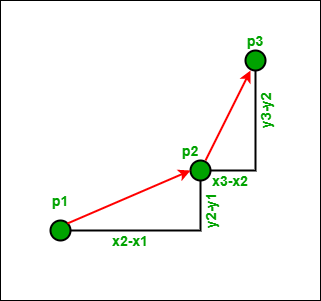

Function *on_segment* checks if a point collinear with an edge is on the edge by simply checking if the point is inside a square aligned with the x and y axis, defined by the edge as the diagonal.

Function *edge_in_polygon* checks if an edge is inside a polygon, this is only possible if both vertices of the edge are part of the same polygon. In this case, the middle point of the segment is inside the polygon, here we don't assume that the obstacles, polygons, are convex, to perfom this check function *point_in_polygon* is used. This function checks if the number of intersections of a half-line from p1 to (-$\infty$, p1.y) and the polygon, if it's an odd number of intersections the point is inside the polygon.

Function *visible_vertices* finds vertices seen from one of the points in the free space. It loops over all of the vertices in the graph, including the start and goal if provided, and checks if there is an intersection between the edge defined by this pair of point and any of the edges of the obstacles. Since the obstacles don't have to be convex, and in case of any obstacle except triangles there are diagonals which might be inside the polygon, this case also needs to be checked by calling the function *edge_in_polygon*.

Function *build_graph* builds the graph based on the global map, the occupied space on the map. This is where the visibility graph is implemented, it calls function *visible_vertices* for all of the points in the graph, including the start and goal, if they are provided and adds the visible edges to the graph.

### A* algorithm

A* algorithm is a search based planning algorithm. It is a best-first search algorithm that uses a cost function and a heuristic function to determine the estimate of cost of a path from start to goal through a node. Heuristic function is an estimate and helps guide the search towards the most promising solution. If the heuristic function doesn't overestimate the actual cost from the node to goal, the algorithm finds the optimal solution, and it is complete if the graph is finite and the cost between any two neighbouring nodes in the graph is non-negative.

In this implementation we know that the graph is going to have finite number of vertices and edges, as well as that the cost between two neighbouring nodes is strictly positive, it is equal to the eucledian distance between the nodes. For the heuristic, again the Eucledian distance is used, it is obvously not overestimating the distance from a node to the goal, if there is no obstacles between the node and the goal, it is going to be equal to the actual cost, while if there is at least one obstacle, then it will underestimate the actual distance. This satisfies the condition for optimality.


The function A* first checks if start and goal node are feasible, and if yes, it creates a temporary graph that captures the connectivity of the start and goal node with the rest of the graph. It loops over the opened nodes, nodes yet to be visited, but those whose neighbour or better yet parent has been visited. Here parent is the node through which we can access a node, the one that preceeds it in the path. In each iteration it takes the currently best node, the one through which the estiamted cost from start to goal is the lowest. If it is the goal node, it extracts the plan, otherwise it continues the search by expanding to the neighbouring nodes in the graph. If the nodes have already been visited or have been opened through another parent, and the cost through this parent is lower than it will be updated, otherwise only if not already opened the node will be added to the opened nodes.


In [1]:
from globalNavigation import*

Let polys be a list of polygons, obstacles, represented as a list of points, the vertices of the polygons. First we create the graph consisting just of the obstacles and obstacle edges, then we build the visibility graph with just the vertices of the obstacles. After that we define the start and goal positions and run the A* algorithm. Testing environment is shown in the picture. (Geogebra online calculator was used for visualisation.)
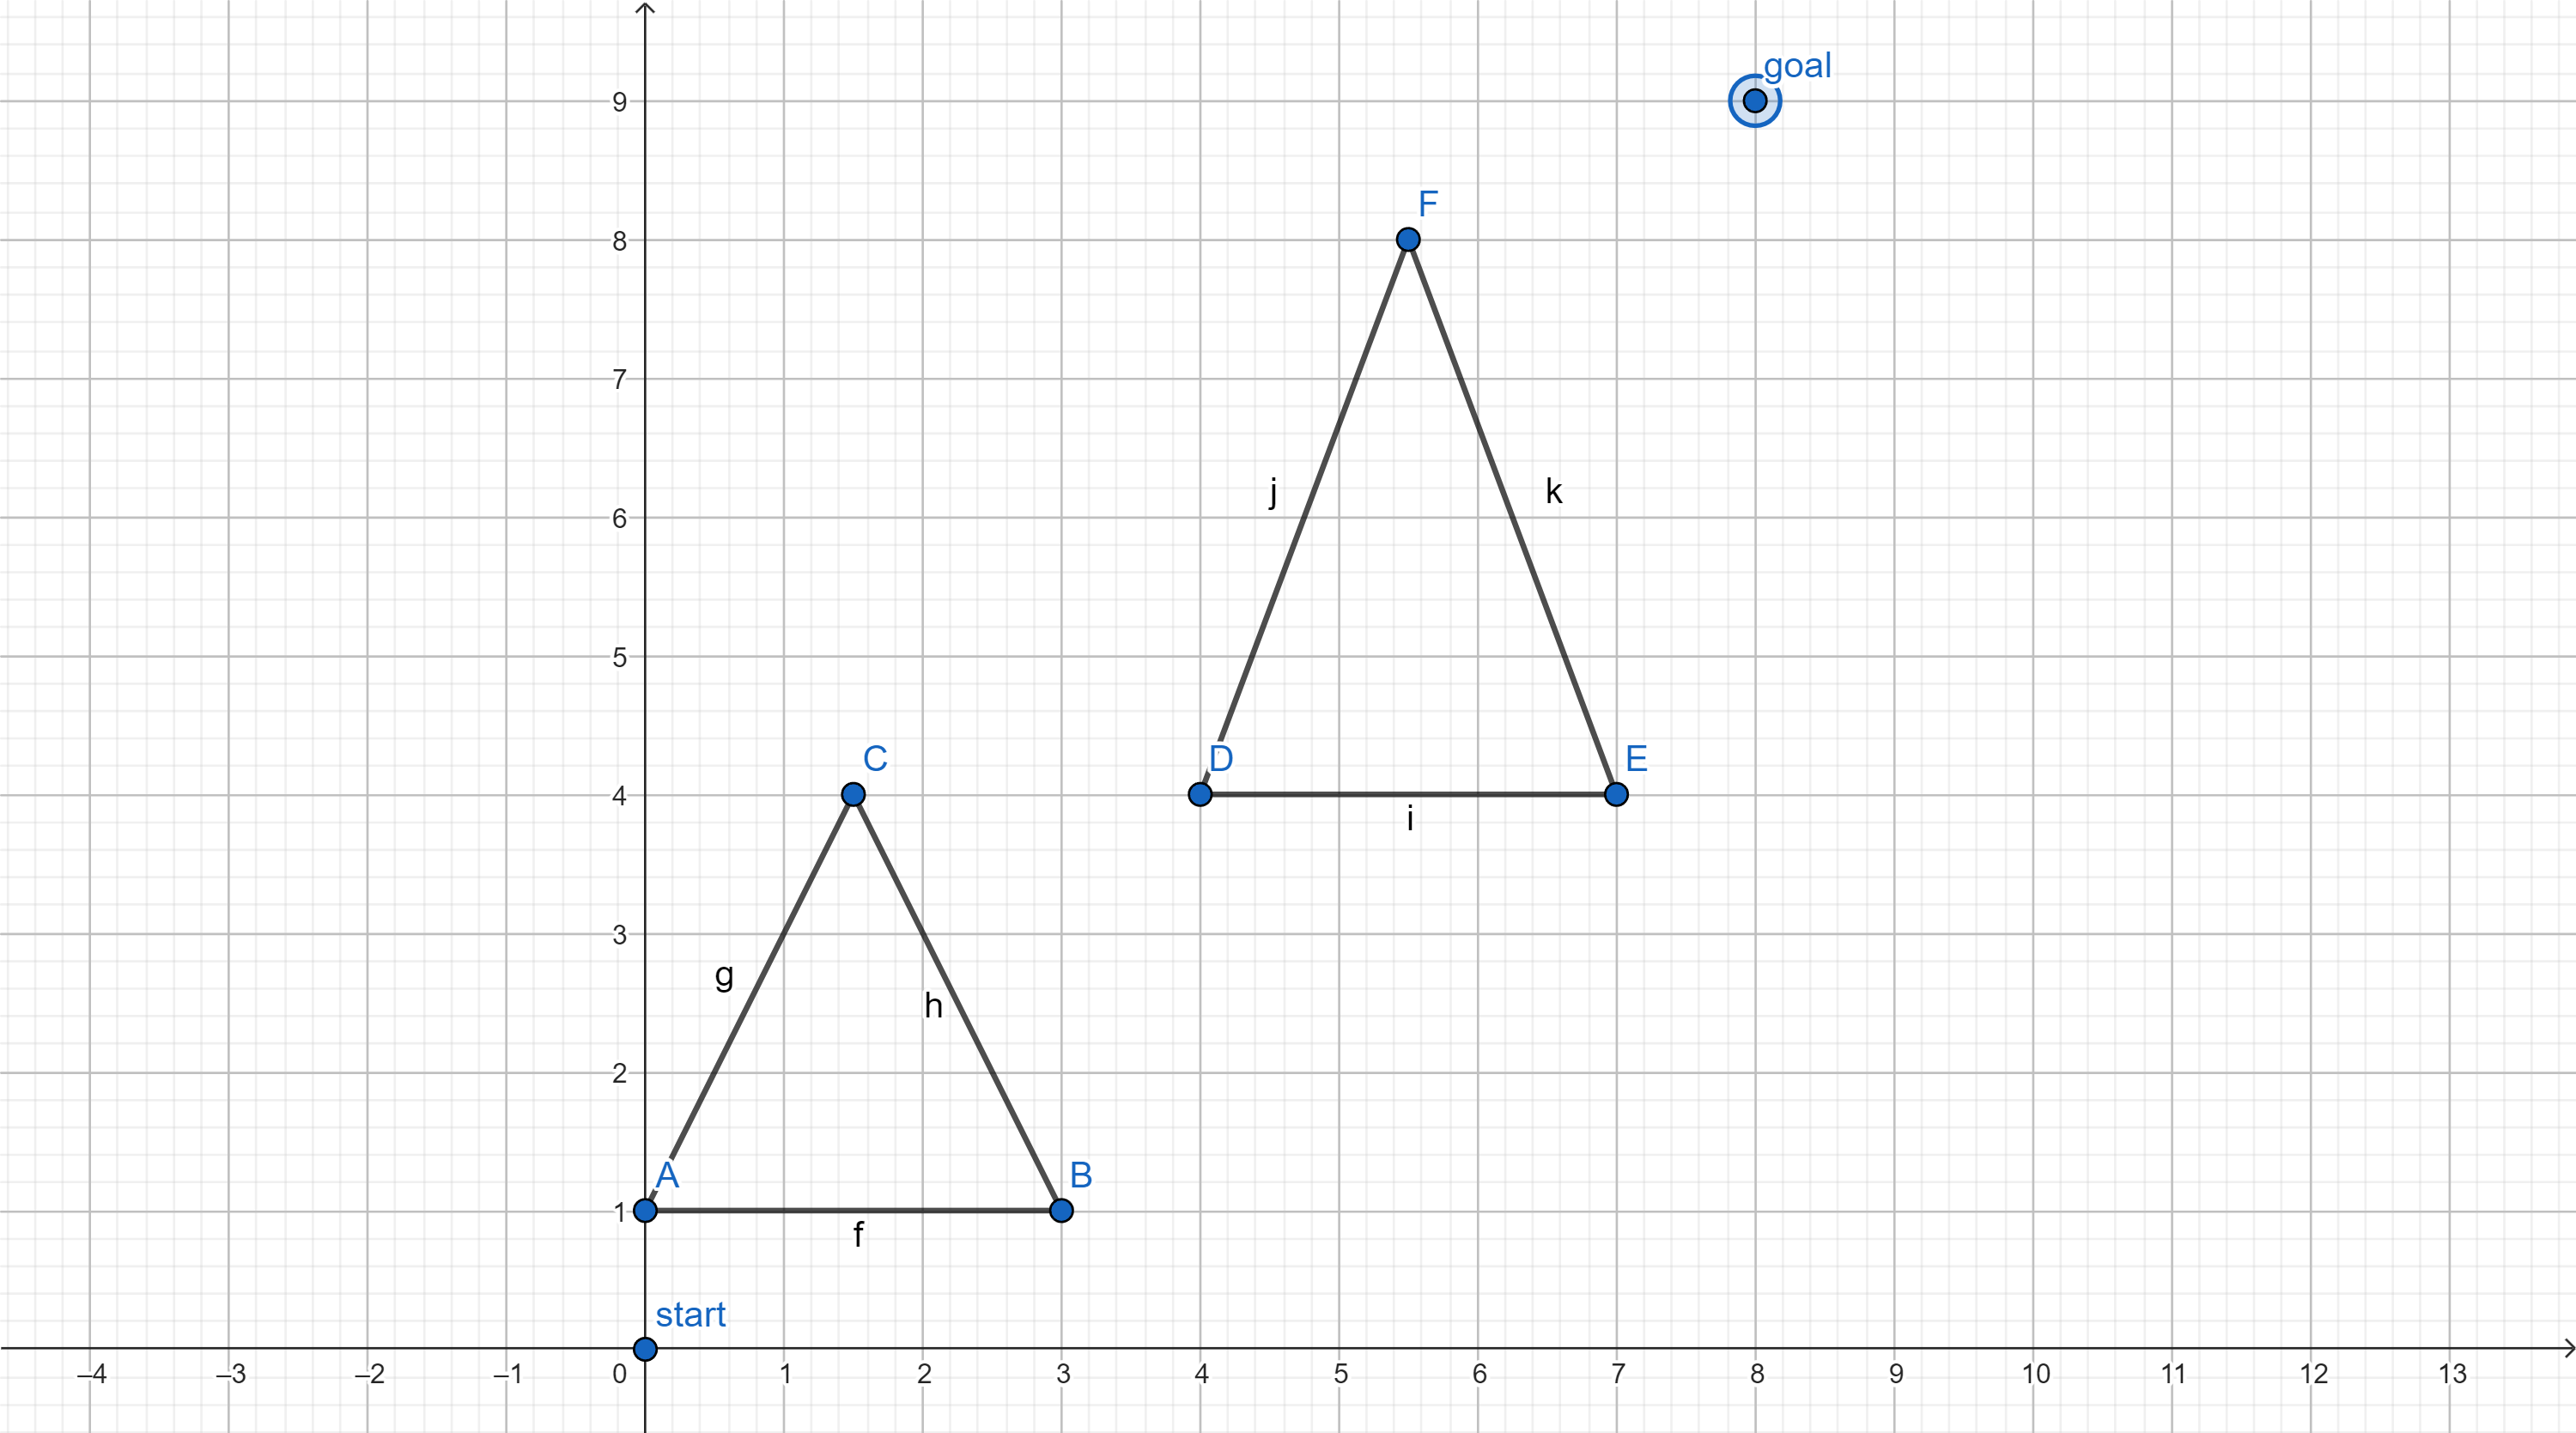

In [8]:
polys = [[Point(0.0,1.0), Point(3.0,1.0), Point(1.5,4.0)], [Point(4.0,4.0), Point(7.0,4.0), Point(5.5,8.0)]]

graph = Graph(polys)
build_graph(graph)

start = Point(0.0,0.0)
goal = Point(8.0, 9.0)


nodes, closed = Astar(graph, start, goal)

nodes = nodes[::-1]
print(nodes)


[Point(0.00, 0.00), Point(0.00, 1.00), Point(1.50, 4.00), Point(5.50, 8.00), Point(8.00, 9.00)]


Here is the testing environment with the found path.
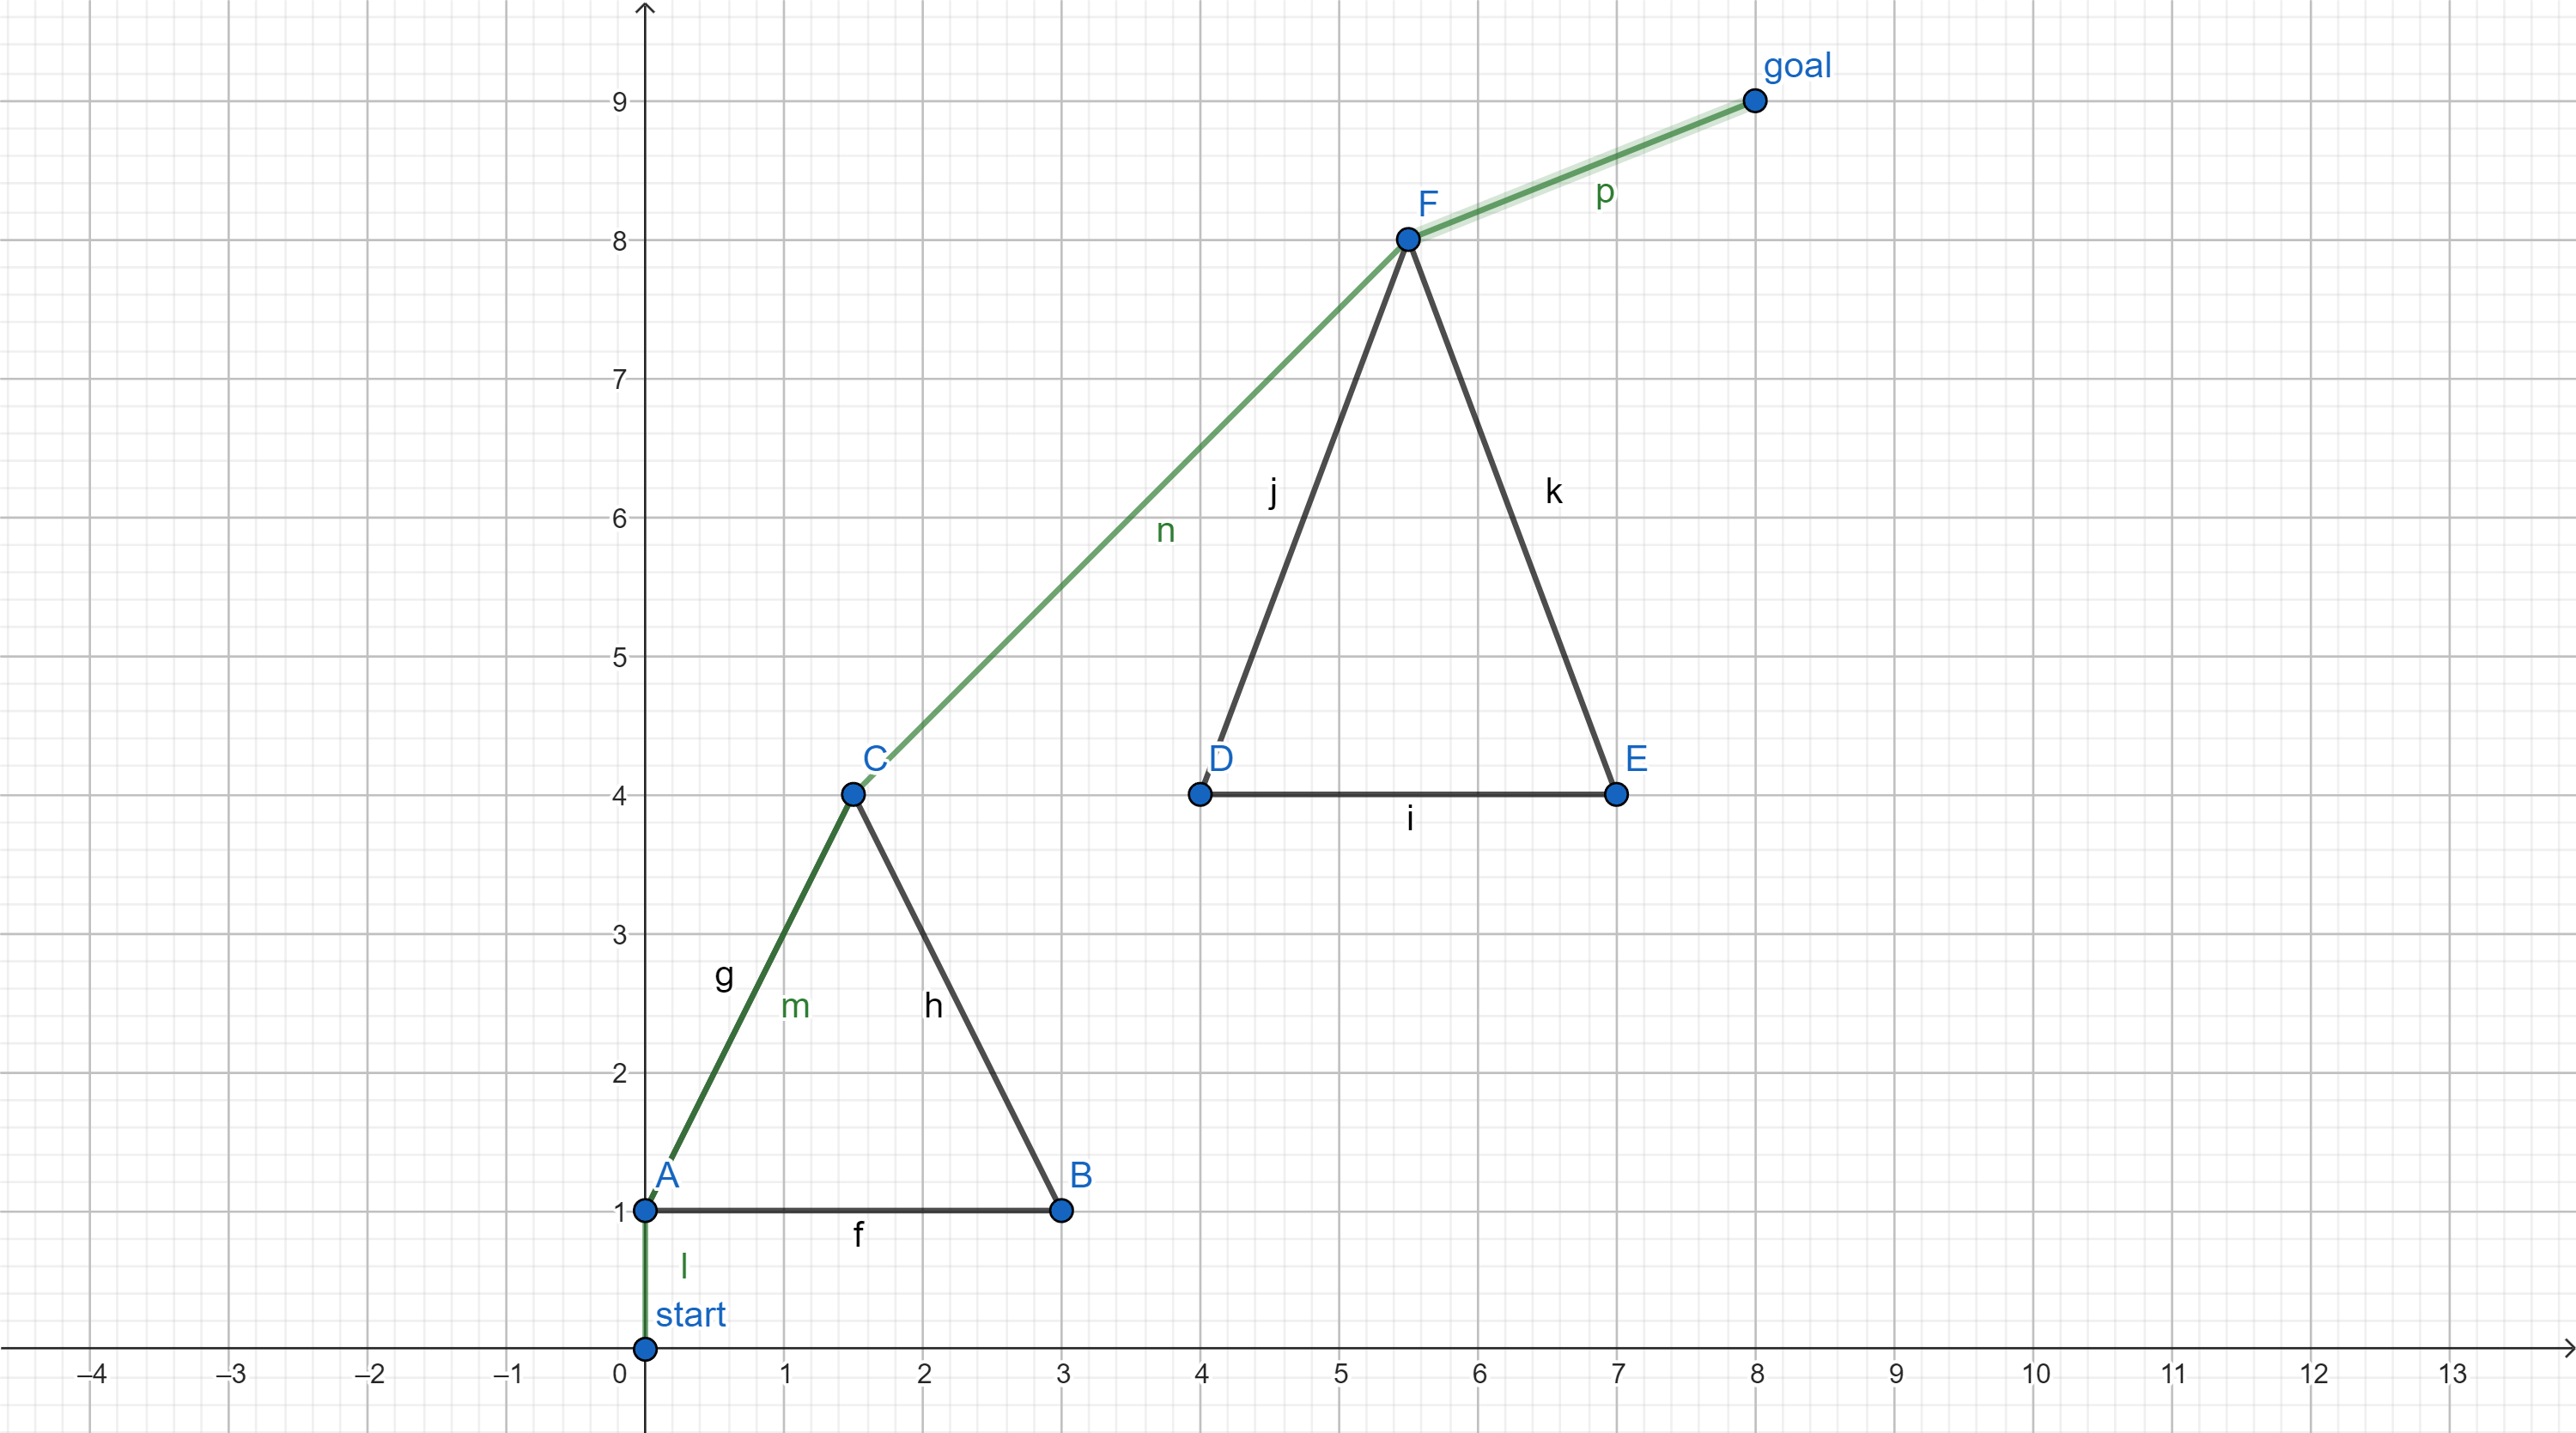